# Hyperparameter Optimization (Intermediate state 1)

This notebook loads the model after 3000 training iterations based on the hyperparameters found with Optuna duing the first performed study. This was done since some of the metrics already were decent at this state. 

## Run notebook from project root

Adjust `path_to_top_dir = "../../"`

In [4]:
import sys
import os

path_to_top_dir = "../../"
sys.path.append(os.path.abspath(path_to_top_dir))

In [5]:
root_path = os.path.abspath(path_to_top_dir)
root_path

'c:\\Users\\paulj\\Desktop\\Master'

In [6]:
os.getcwd()

'c:\\Users\\paulj\\Desktop\\Master\\trials\\hyperparameter_tuning'

## Imports

In [7]:
import seaborn as sns
import shutil
from omegaconf import OmegaConf
from collections import defaultdict
from src.submodels.openpom.functions import fragance_propabilities_from_smiles

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
c:\Users\paulj\Desktop\Master\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [8]:
import copy
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator
import sqlite3
from rdkit.Chem.Draw import MolsToGridImage, MolToImage
import numpy as np
from rdkit import Chem
from torch_scatter import scatter
import pandas as pd
import pathlib
from src.submodels.gflownet.algo.config import TBVariant
from src.submodels.gflownet.config import Config,init_empty
import torch
import gc
from src.model.scent_trainer import ScentTrainer


############################################################
#                     Initialize MCFs                      #
############################################################

Filter                                        Min        Max
------------------------------------------------------------
LogP                                         0.06       4.91
Molecular Weight                           100.12     282.46
HBAB + HBD                                   0.00       5.00
TPSA                                         0.00      63.32
Rotatable Bonds                              0.00      11.00
NO2 Groups                                   0.00       0.00
Heteroatoms                                  0.00       4.00
Aromatic Rings                               0.00       1.00
Atom Count                                   0.00      20.00
Triple Bonds                                 0.00       0.00
Oxygen Chain Length                          0.00       1.00

#####################

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\paulj\Desktop\Master\venv\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Initialize

Specify save directory. A copy of this directory will be created for the new trainer object.

In [9]:
save_base="hyperbest loong 3000 load"
save_index = 0
if save_index != 0:
    save_name = f"{save_base}_{save_index}"
else:
    save_name = save_base

In [10]:
original_log_dir = os.path.join(root_path, f"logs/{save_name}/")
original_log_dir

'c:\\Users\\paulj\\Desktop\\Master\\logs/hyperbest loong 3000 load/'

## Loading Functions

In [11]:
import re

def increment_name(name):
    # Regex to capture the base name and optional number suffix
    match = re.match(r"^(.*?)(?:_(\d+))?$", name)
    if not match:
        return name + "_1"
    
    base = match.group(1)
    num = match.group(2)
    
    if num is None:
        return f"{base}_1"
    else:
        return f"{base}_{int(num) + 1}"

def init_proceed_training(prev_log_dir):
    if prev_log_dir[-1] == "/":
        new_log_dir = increment_name(prev_log_dir[:-1])
    else:
        new_log_dir = increment_name(prev_log_dir)
    
    if not os.path.exists(new_log_dir):
        shutil.copytree(prev_log_dir,new_log_dir)
        print(f"Create new directory: {new_log_dir}")
    else:
        raise FileExistsError(f"Save directory {new_log_dir} already exists - Abort")
    return new_log_dir,prev_log_dir
    

In [12]:


def load_trainer_from_checkpoint(prev_log_dir: str, trainer_class: type, start_at_step:int=None, num_training_steps:int=None, id:int=0):
    
    log_dir, prev_log_dir = init_proceed_training(prev_log_dir)
    checkpoint_path = os.path.join(log_dir, "model_final_save.pt")
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    
    # Restore the config
    cfg = checkpoint["cfg"]
    cfg = OmegaConf.to_container(cfg, resolve=True)  
    cfg_obj = OmegaConf.structured(Config)             
    cfg_merged = OmegaConf.merge(cfg_obj, cfg)     
    cfg = OmegaConf.to_object(cfg_merged)  

    if log_dir != cfg.log_dir:
        cfg.log_dir = log_dir

    # Ensure the correct start step
    if start_at_step:
        cfg.start_at_step = start_at_step
    else:
        cfg.start_at_step = cfg.num_training_steps
    print(f"Start at step: {cfg.start_at_step}")

    # Ensure the correct start step
    if num_training_steps:
        cfg.num_training_steps = cfg.start_at_step+num_training_steps
    else:
        cfg.num_training_steps = cfg.start_at_step+cfg.num_training_steps


    # If log_dir exists and shouldn't be overwritten, disable deletion
    cfg.overwrite_existing_exp = True

    # Instantiate the trainer
    trainer = trainer_class(cfg)

    # Load model weights
    trainer.model.load_state_dict(checkpoint["models_state_dict"][0])
    if "sampling_model_state_dict" in checkpoint:
        trainer.sampling_model.load_state_dict(checkpoint["sampling_model_state_dict"][0])
    else:
        trainer.sampling_model.load_state_dict(checkpoint["models_state_dict"][0])
    trainer.model.eval()
    trainer.sampling_model.eval()

    trainer.model.to(trainer.device)
    trainer.sampling_model.to(trainer.device)


    return trainer, cfg, prev_log_dir


In [13]:
def save_run(trial):
    state = {
        "models_state_dict": [trial.model.state_dict()],
        "cfg": trial.cfg,
        "env_ctx": trial.model.env_ctx,
        #"model": trial.model,
    }
    if trial.sampling_model is not trial.model:
        state["sampling_model_state_dict"] = [trial.sampling_model.state_dict()]
    fn = pathlib.Path(trial.cfg.log_dir) / "model_final_save.pt"
    with open(fn, "wb") as fd:
        torch.save(
            state,
            fd,
        )

In [14]:
def continue_training(trainer,prev_log_dir):
    trainer.run()
    #with open(os.path.join(prev_log_dir, "train.log"), "r") as f_old, open(os.path.join(trainer.cfg.log_dir, "train.log"), "a") as f_new:
    save_run(trainer)

    gc.collect()
    # Read contents
    with open(os.path.join(prev_log_dir, "train.log"), "r", encoding="utf-8") as f_old:
        old_content = f_old.read()
    with open(os.path.join(trainer.cfg.log_dir, "train.log"), "r", encoding="utf-8") as f_new:
        new_content = f_new.read()

    #   Write new file with old content first
    with open(os.path.join(trainer.cfg.log_dir, "train.log"), "w", encoding="utf-8") as f_new:
        f_new.write(old_content)
        f_new.write(new_content)



In [15]:
def merge_event_scalars(log_dirs):
    merged_scalars = defaultdict(list)  # tag -> list of events (across all logs)

    for log_dir in log_dirs:
        ea = event_accumulator.EventAccumulator(log_dir)
        ea.Reload()

        # Get all scalar tags in this log directory
        tags = ea.Tags().get('scalars', [])

        for tag in tags:
            merged_scalars[tag].extend(ea.Scalars(tag))

    
    #for tag, events in merged_scalars.items():
        #merged_scalars[tag] = sorted(events, key=lambda e: e.step)
    return merged_scalars, merged_scalars[tag][-1].step

In [16]:
def find_immediate_subdirs_with_string(log_dir,substring):
    root_dir = os.path.dirname(log_dir.rstrip("/"))
    return [
        os.path.join(root_dir, d)
        for d in os.listdir(root_dir)
        if os.path.isdir(os.path.join(root_dir, d)) and substring in d and "validation" not in d
    ]

In [17]:
def get_training_df(log_dirs):
    training_df = pd.DataFrame()
    for l_dir in log_dirs:
        if not os.path.exists(f"{l_dir}/train/generated_objs_0.db"):
            print(f"DB files does not exist for {l_dir}")
            continue
        conn = sqlite3.connect(f"{l_dir}/train/generated_objs_0.db")
        new_training_df = pd.read_sql_query("SELECT * FROM results", conn)
        training_df = pd.concat([training_df, new_training_df], ignore_index=True)
    return training_df

## Initialize Trainer

In [18]:
log_dirs = find_immediate_subdirs_with_string(original_log_dir,save_base)
log_dirs

['c:\\Users\\paulj\\Desktop\\Master\\logs\\hyperbest loong 3000 load']

In [19]:
_, start_at_step = merge_event_scalars(log_dirs)
start_at_step

3000

In [21]:
gc.collect()
trainer, cfg, prev_log_dir = load_trainer_from_checkpoint(
    original_log_dir, 
    ScentTrainer, 
    start_at_step=start_at_step, 
    num_training_steps=1
    )

Create new directory: c:\Users\paulj\Desktop\Master\logs/hyperbest loong 3000 load_1
Start at step: 3000


Hyperparameters:

desc: noDesc
log_dir: c:\Users\paulj\Desktop\Master\logs/hyperbest loong 3000 load_1
device: cpu
seed: 0
validate_every: 1000
checkpoint_every: null
store_all_checkpoints: false
print_every: 1
start_at_step: 3000
num_final_gen_steps: null
num_validation_gen_steps: 1
num_training_steps: 3001
num_workers: 0
hostname: LAPTOP-JIE0TNQT
pickle_mp_messages: false
git_hash: d209ba9
overwrite_existing_exp: true
algo:
  method: TB
  num_from_policy: 32
  num_from_dataset: 32
  valid_num_from_policy: 32
  valid_num_from_dataset: 32
  max_len: 128
  max_nodes: 20
  max_edges: 128
  illegal_action_logreward: -75.0
  train_random_action_prob: 0.001
  train_det_after: null
  valid_random_action_prob: 0.0
  sampling_tau: 0.9586388653961274
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_multiplier: 1.0
    variant: SubTB1
    do_correct_idempotent: false


## Validation

In [22]:
#np.array_equal(old_test_data,trainer.test_data.idcs), np.array_equal(old_training_data,trainer.training_data.idcs)
#old_test_data, old_training_data = trainer.test_data.idcs,trainer.training_data.idcs

### Run Validation

In [23]:
batch_idx = trainer.cfg.num_training_steps % max(len(trainer.training_data),1)
epoch_idx = trainer.cfg.num_training_steps // max(len(trainer.training_data),1)
batch_idx,epoch_idx

(3001, 0)

In [24]:
validation_config = copy.deepcopy(cfg)
validation_config.algo.valid_num_from_policy= 0
validation_config.algo.valid_num_from_dataset= 1
validation_config.log_dir = trainer.cfg.log_dir[:-1] + "_validation"
validation_trainer = ScentTrainer(validation_config, print_config=False)
validation_trainer.model = copy.deepcopy(trainer.model)
validation_trainer.sampling_model = copy.deepcopy(trainer.model)
validation_trainer.training_data = copy.deepcopy(trainer.training_data)
validation_trainer.test_data = copy.deepcopy(trainer.test_data)

In [25]:
validation_config

Config(desc='noDesc', log_dir='c:\\Users\\paulj\\Desktop\\Master\\logs/hyperbest loong 3000 load__validation', device='cpu', seed=0, validate_every=1000, checkpoint_every=None, store_all_checkpoints=False, print_every=1, start_at_step=3000, num_final_gen_steps=None, num_validation_gen_steps=1, num_training_steps=3001, num_workers=0, hostname='LAPTOP-JIE0TNQT', pickle_mp_messages=False, git_hash='e7c59a8', overwrite_existing_exp=True, algo=AlgoConfig(method='TB', num_from_policy=32, num_from_dataset=32, valid_num_from_policy=0, valid_num_from_dataset=1, max_len=128, max_nodes=20, max_edges=128, illegal_action_logreward=-75.0, train_random_action_prob=0.001, train_det_after=None, valid_random_action_prob=0.0, sampling_tau=0.9586388653961274, tb=TBConfig(bootstrap_own_reward=False, epsilon=None, reward_loss_multiplier=1.0, variant=<TBVariant.SubTB1: 1>, do_correct_idempotent=False, do_parameterize_p_b=False, do_predict_n=False, do_sample_p_b=False, do_length_normalize=False, subtb_max_len

In [26]:
n_drawn = validation_trainer.cfg.algo.valid_num_from_policy
n_from_dataset = validation_trainer.cfg.algo.valid_num_from_dataset
n_drawn,n_from_dataset

(0, 1)

In [27]:
valid_dl = validation_trainer.build_validation_data_loader()
df = trainer.test_data.df.iloc[validation_trainer.test_data.idcs]
#valid_df = pd.DataFrame()
rows = []



for batch, smiles in zip(valid_dl, df["nonStereoSMILES"]):
    info = validation_trainer.evaluate_batch(batch.to(validation_trainer.device), epoch_idx, batch_idx)
    batch_idx_ = torch.arange(n_from_dataset, device=validation_trainer.device).repeat_interleave(batch.traj_lens)
    cond_info = getattr(batch, "cond_info", None)
    batched_cond_info = cond_info[batch_idx_] if cond_info is not None else None
    fwd_cat, per_graph_out = validation_trainer.model(batch, batched_cond_info)
    log_pF = fwd_cat.log_prob(batch.actions)
    traj_log_p_F = scatter(log_pF, batch_idx_, dim=0, dim_size=n_from_dataset, reduce="sum")
    log_p_B = batch.log_p_B
    traj_log_p_B = scatter(log_p_B, batch_idx_, dim=0, dim_size=n_from_dataset, reduce="sum")
    log_rewards = batch.log_rewards

    row = {
        'SMILES': smiles,
        'traj_p_F': traj_log_p_F.exp().item(),  
        'traj_p_B': traj_log_p_B.exp().item(),
        'reward': log_rewards.exp().item()
    }
    row = { **row, **info}
    rows.append(row)
    
    print(f"{smiles:<40} traj_p_F:{traj_log_p_F.exp().item():.5f} traj_p_B:{traj_log_p_B.exp().item():.5f} reward:{log_rewards.exp().item():.2f}" + " ".join(f"{k}:{v:.2f}" for k, v in info.items()))
    gc.collect()
valid_df = pd.DataFrame(rows)

CCCCCC(=O)OCCc1ccccc1                    traj_p_F:0.00000 traj_p_B:0.00000 reward:0.79offline_loss:18.14 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:6.19 loss:18.14 n_loss:0.00 tb_loss:18.14 batch_entropy:44.48 traj_lens:22.00 eval_time:0.09
CC1=CCC(=C(C)C)CC1                       traj_p_F:0.00000 traj_p_B:0.00000 reward:0.69offline_loss:7.22 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:6.19 loss:7.22 n_loss:0.00 tb_loss:7.22 batch_entropy:29.41 traj_lens:14.00 eval_time:0.05
CC1=C(O)C(=O)C(C)C1C                     traj_p_F:0.00000 traj_p_B:0.00000 reward:0.83offline_loss:16.95 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:6.19 loss:16.95 n_loss:0.00 tb_loss:16.95 batch_entropy:33.49 traj_lens:14.00 eval_time:0.05
CCCCCCCCCCCC(OC)OC       

In [28]:
valid_df.to_csv(os.path.join(trainer.cfg.log_dir, "example_validation.csv"),index=None)
valid_df.head()


,SMILES,traj_p_F,traj_p_B,reward,offline_loss,online_loss,reward_loss,invalid_trajectories,invalid_logprob,invalid_losses,backward_vs_unif,logZ,loss,n_loss,tb_loss,batch_entropy,traj_lens,eval_time
0,CCCCCC(=O)OCCc1ccccc1,4.822374e-20,4.905743e-11,0.789376,18.137547,0,0,0,0.0,0.0,0.0,6.188434,18.137547,0.0,18.137547,44.478436,22.0,0.091174
1,CC1=CCC(=C(C)C)CC1,1.688849e-13,1.476285e-07,0.689498,7.221236,0,0,0,0.0,0.0,0.0,6.188434,7.221236,0.0,7.221236,29.409559,14.0,0.046025
2,CC1=C(O)C(=O)C(C)C1C,2.866864e-15,8.573382e-08,0.830900,16.947611,0,0,0,0.0,0.0,0.0,6.188434,16.947611,0.0,16.947611,33.485558,14.0,0.050602
3,CCCCCCCCCCCC(OC)OC,8.957388e-14,9.042257e-06,0.597757,14.457475,0,0,0,0.0,0.0,0.0,6.188434,14.457475,0.0,14.457475,30.043713,17.0,0.078119
4,N#CC=Cc1ccccc1,6.505728e-18,4.236786e-09,0.904247,21.028233,0,0,0,0.0,0.0,0.0,6.188434,21.028233,0.0,21.028233,39.573849,17.0,0.046874


In [29]:
gc.collect()

136

### Visualize validation

In [30]:
valid_df[["reward","loss"]].mean()

reward      0.697542
loss      144.290079
dtype: float64

In [31]:
valid_df[["reward","loss"]].median()

reward     0.671449
loss      11.772722
dtype: float64

In [32]:
valid_df[["reward","loss"]].max()

reward        0.996399
loss      19285.031250
dtype: float64

In [33]:
valid_df[["reward","loss"]].min()

reward    0.303542
loss      0.694303
dtype: float64

Trajectory probability $p_F(\tau)$ vs. reward R(x). High rewards should have a high probability

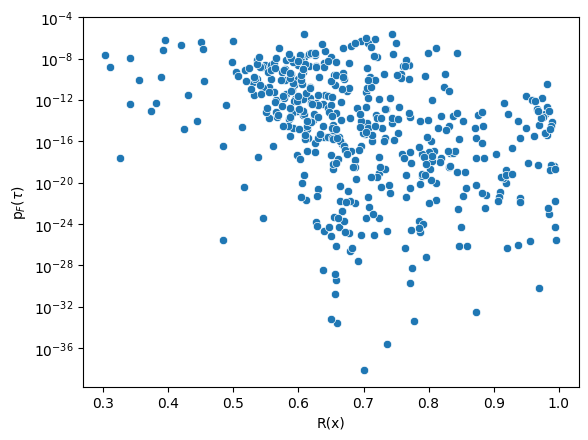

In [34]:
sns.scatterplot(valid_df, x="reward", y="traj_p_F")
plt.yscale("log")
plt.xlabel("R(x)")
plt.ylabel(r"p$_F(\tau)$")
plt.show()

Loss vs. reward R(x). High rewards should have a low loss.

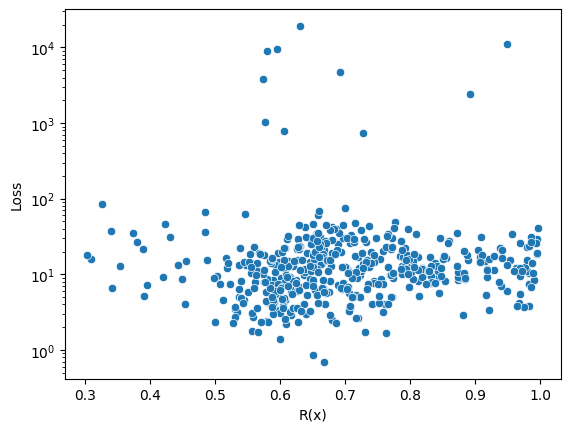

In [35]:
sns.scatterplot(valid_df, x="reward", y="loss")
plt.yscale("log")
plt.xlabel("R(x)")
plt.ylabel(r"Loss")
plt.show()

Loss vs. reward R(x). 

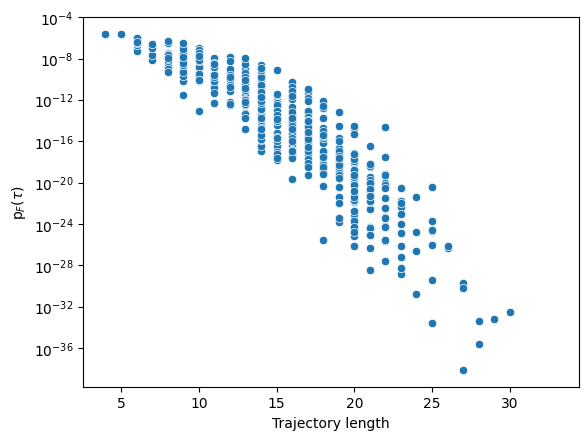

In [36]:
sns.scatterplot(valid_df, x="traj_lens", y="traj_p_F")
plt.yscale("log")
plt.xlabel("Trajectory length")
plt.ylabel(r"p$_F(\tau)$")
plt.show()

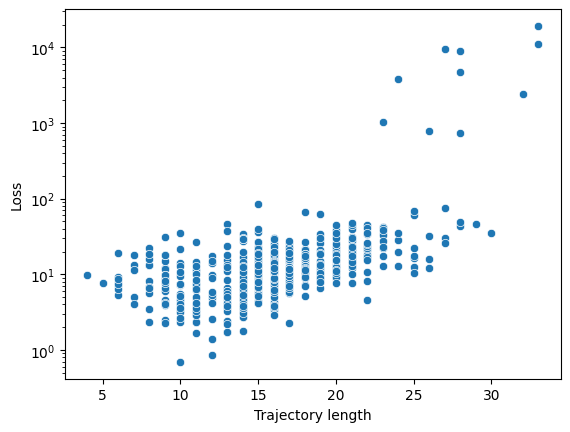

In [37]:
sns.scatterplot(valid_df, x="traj_lens", y="loss")
plt.yscale("log")
plt.xlabel("Trajectory length")
plt.ylabel(r"Loss")
plt.show()

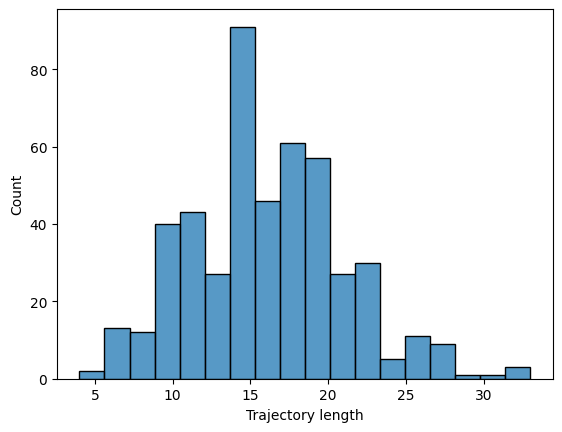

In [38]:
sns.histplot(data=valid_df, x="traj_lens")
plt.xlabel("Trajectory length")
plt.show()

## Training Metrics

In [39]:
log_dirs = find_immediate_subdirs_with_string(original_log_dir,save_base)
log_dirs

event_scalars, _ = merge_event_scalars(log_dirs)

In [40]:
[ e.step for e in event_scalars['train_loss']] == [i+1 for i in range(3000)]

True

In [41]:
log_dirs = find_immediate_subdirs_with_string(original_log_dir,save_base)
log_dirs

['c:\\Users\\paulj\\Desktop\\Master\\logs\\hyperbest loong 3000 load',
 'c:\\Users\\paulj\\Desktop\\Master\\logs\\hyperbest loong 3000 load_1']

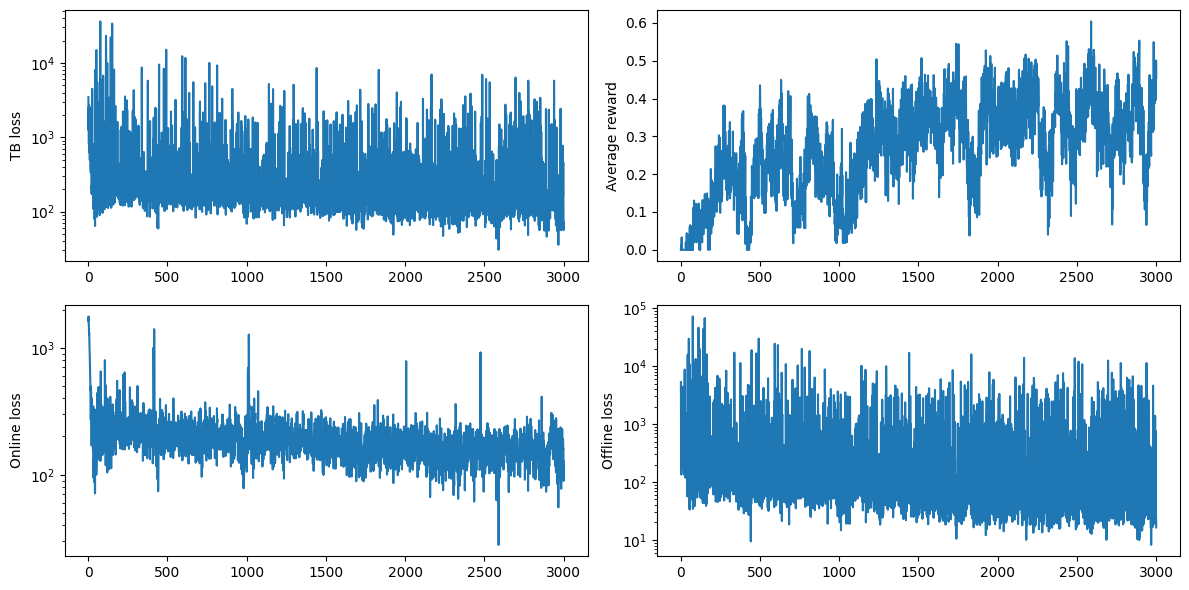

In [42]:


event_scalars, _ = merge_event_scalars(log_dirs)
x = [i+1 for i in range(len(event_scalars['train_loss']))]
f, ax = plt.subplots(2, 2, figsize=(4*3,6))
sns.lineplot(y=[ e.value for e in event_scalars['train_loss']],x=x, ax=ax[0,0])
ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('TB loss')
sns.lineplot(y=[ e.value for e in event_scalars['train_sampled_reward_avg']],x=x, ax=ax[0,1])
ax[0,1].set_ylabel('Average reward')
sns.lineplot(y=[ e.value for e in event_scalars['train_online_loss']],x=x, ax=ax[1,0])
ax[1,0].set_yscale('log')
ax[1,0].set_ylabel('Online loss')
sns.lineplot(y=[ e.value for e in event_scalars['train_offline_loss']],x=x, ax=ax[1,1])
ax[1,1].set_yscale('log')
ax[1,1].set_ylabel('Offline loss')
plt.tight_layout()

## Generate Molecules

### Functions

In [43]:
def sample_molecules_from_model(gen_trainer, amont=25):
    # Generate molecules
    trajs = gen_trainer.algo.create_training_data_from_own_samples(gen_trainer.model, amont)
    objs = [gen_trainer.ctx.graph_to_obj(i['result']) for i in trajs]
    obj_props, is_valid = gen_trainer.task.compute_obj_properties(objs)
    cond_info = gen_trainer.task.sample_conditional_information(len(obj_props), 1)
    log_rewards = gen_trainer.task.cond_info_to_logreward(cond_info, obj_props)
    
    valid_idcs = torch.tensor([i for i in range(len(trajs)) if trajs[i].get("is_valid", True)]).long()    

    valid_idcs = valid_idcs[is_valid]
    all_fr = torch.zeros((len(trajs), obj_props.shape[1]))
    all_fr[valid_idcs] = obj_props
    rewards = all_fr.flatten()

    return objs, obj_props, is_valid, rewards, log_rewards, trajs, cond_info

In [44]:
def get_n_top_molecules(n):
    top_rewards = training_df.sort_values(by='r', ascending=False).head(n)
    objs = [Chem.MolFromSmiles(smiles) for smiles in top_rewards["smi"]]
    rewards = top_rewards["r"]
    return objs, rewards

In [45]:
def get_last_molecules(cfg, df):
    n = cfg.algo.valid_num_from_policy
    objs = [Chem.MolFromSmiles(smiles) for smiles in df[-n:]["smi"]]
    rewards = df[-n:]["r"]
    return objs, rewards

### Plots

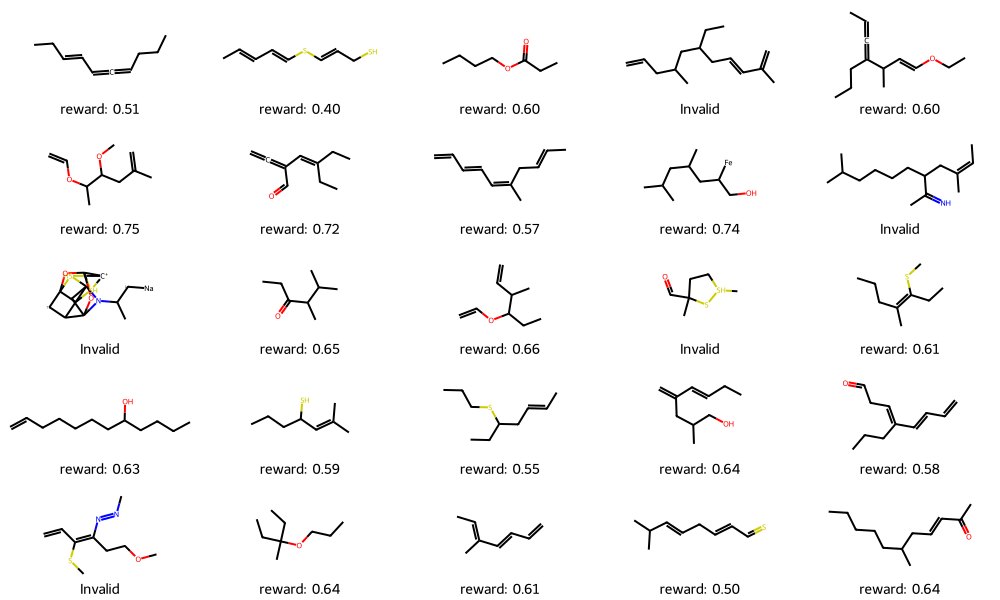

In [47]:
objs, obj_props, is_valid, rewards, log_rewards, trajs, cond_info = sample_molecules_from_model(trainer, amont=25)
MolsToGridImage(objs, molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r:.2f}' if r != 0 else "Invalid" for r in rewards  ])

## Analyze Training Molcules

In [48]:
log_dirs

['c:\\Users\\paulj\\Desktop\\Master\\logs\\hyperbest loong 3000 load',
 'c:\\Users\\paulj\\Desktop\\Master\\logs\\hyperbest loong 3000 load_1']

In [49]:
training_df = get_training_df(log_dirs)

DB files does not exist for c:\Users\paulj\Desktop\Master\logs\hyperbest loong 3000 load_1


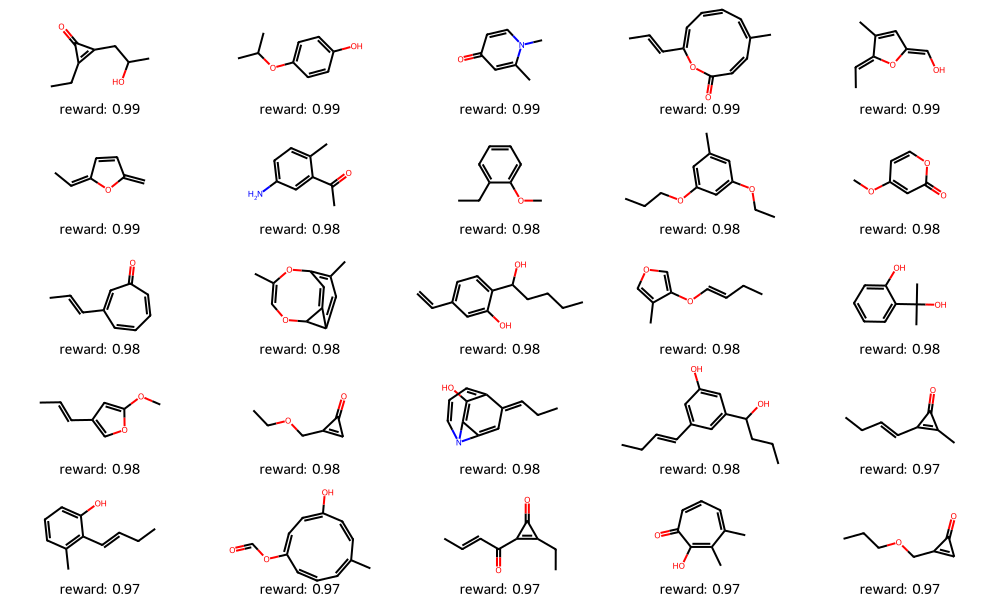

In [50]:
objs, rewards = get_n_top_molecules(25)
MolsToGridImage(objs, molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r:.2f}' for r in rewards])

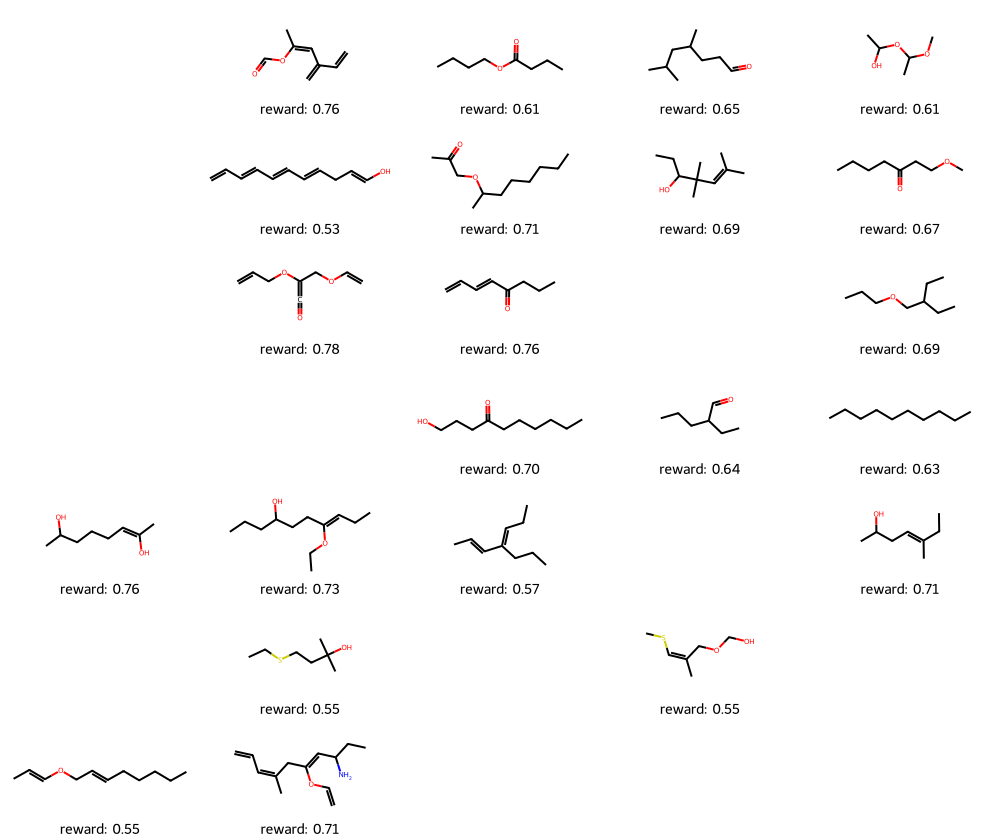

In [51]:
objs, rewards = get_last_molecules(trainer.cfg, training_df) 
MolsToGridImage(objs, molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r:.2f}' for r in rewards])

## Prepare Validation files

Sample model 10000 times. Done iterativly due to memory restrictions. 

In [57]:
cwd = os.getcwd()
cwd

'c:\\Users\\paulj\\Desktop\\Master\\trials\\hyperparameter_tuning'

#### Helpers

In [58]:
from src.submodels.gflownet.algo.config import Backward, LossFN, NLoss,TBVariant
from src.submodels.gflownet.envs.graph_building_env import ActionIndex, Graph, GraphAction, GraphActionCategorical,GraphActionType, GraphBuildingEnv, GraphBuildingEnvContext
from src.submodels.gflownet.algo.trajectory_balance import shift_right
def compute_batch_losses(
        algo,
        model,
        batch,
        num_bootstrap: int = 0,  # type: ignore[override]
    ):
        """Compute the losses over trajectories contained in the batch

        Parameters
        ----------
        model: TrajectoryBalanceModel
           A GNN taking in a batch of graphs as input as per constructed by `self.construct_batch`.
           Must have a `logZ` attribute, itself a model, which predicts log of Z(cond_info)
        batch: gd.Batch
          batch of graphs inputs as per constructed by `self.construct_batch`
        num_bootstrap: int
          the number of trajectories for which the reward loss is computed. Ignored if 0."""
        dev = batch.x.device
        # A single trajectory is comprised of many graphs
        num_trajs = int(batch.traj_lens.shape[0])
        log_rewards = batch.log_rewards
        # Clip rewards
        assert log_rewards.ndim == 1
        clip_log_R = torch.maximum(
            log_rewards, torch.tensor(algo.global_cfg.algo.illegal_action_logreward, device=dev)
        ).float()
        #print("num_trajs:", num_trajs)
        #print("log_rewards:", log_rewards)
        #print("clip_log_R:", clip_log_R)
        cond_info = getattr(batch, "cond_info", None)
        invalid_mask = 1 - batch.is_valid
        #print("invalid_mask:", invalid_mask)
        # This index says which trajectory each graph belongs to, so
        # it will look like [0,0,0,0,1,1,1,2,...] if trajectory 0 is
        # of length 4, trajectory 1 of length 3, and so on.
        batch_idx = torch.arange(num_trajs, device=dev).repeat_interleave(batch.traj_lens)
        # The position of the last graph of each trajectory
        traj_cumlen = torch.cumsum(batch.traj_lens, 0)
        final_graph_idx = traj_cumlen - 1
        # The position of the first graph of each trajectory
        first_graph_idx = shift_right(traj_cumlen)
        final_graph_idx_1 = torch.maximum(final_graph_idx - 1, first_graph_idx)

        fwd_cat: GraphActionCategorical  # The per-state cond_info
        batched_cond_info = cond_info[batch_idx] if cond_info is not None else None
        #print(batch_idx,first_graph_idx,final_graph_idx_1)
    

        # Forward pass of the model, returns a GraphActionCategorical representing the forward
        # policy P_F, optionally a backward policy P_B, and per-graph outputs (e.g. F(s) in SubTB).
        if algo.cfg.do_parameterize_p_b:
            fwd_cat, bck_cat, per_graph_out = model(batch, batched_cond_info)
        else:
            if algo.model_is_autoregressive:
                fwd_cat, per_graph_out = model(batch, cond_info, batched=True)
            else:
                fwd_cat, per_graph_out = model(batch, batched_cond_info)
        
        # Retreive the reward predictions for the full graphs,
        # i.e. the final graph of each trajectory
        log_reward_preds = per_graph_out[final_graph_idx, 0]
        if algo.cfg.do_predict_n:
            log_n_preds = per_graph_out[:, 1]
            log_n_preds[first_graph_idx] = 0
        else:
            log_n_preds = None

        # Compute trajectory balance objective
        log_Z = model.logZ(cond_info)[:, 0]

        # Compute the log prob of each action in the trajectory
        if algo.cfg.do_correct_idempotent:
            # If we want to correct for idempotent actions, we need to sum probabilities
            # i.e. to compute P(s' | s) = sum_{a that lead to s'} P(a|s)
            # here we compute the indices of the graph that each action corresponds to, ip_lens
            # contains the number of idempotent actions for each transition, so we
            # repeat_interleave as with batch_idx
            ip_batch_idces = torch.arange(batch.ip_lens.shape[0], device=dev).repeat_interleave(batch.ip_lens)
            # Indicate that the `batch` corresponding to each action is the above
            ip_log_prob = fwd_cat.log_prob(batch.ip_actions, batch=ip_batch_idces)
            # take the logsumexp (because we want to sum probabilities, not log probabilities)
            # TODO: numerically stable version:
            p = scatter(ip_log_prob.exp(), ip_batch_idces, dim=0, dim_size=batch_idx.shape[0], reduce="sum")
            # As a (reasonable) band-aid, ignore p < 1e-30, this will prevent underflows due to
            # scatter(small number) = 0 on CUDA
            log_p_F = p.clamp(1e-30).log()

            if algo.cfg.do_parameterize_p_b:
                # Now we repeat this but for the backward policy
                bck_ip_batch_idces = torch.arange(batch.bck_ip_lens.shape[0], device=dev).repeat_interleave(
                    batch.bck_ip_lens
                )
                bck_ip_log_prob = bck_cat.log_prob(batch.bck_ip_actions, batch=bck_ip_batch_idces)
                bck_p = scatter(
                    bck_ip_log_prob.exp(), bck_ip_batch_idces, dim=0, dim_size=batch_idx.shape[0], reduce="sum"
                )
                log_p_B = bck_p.clamp(1e-30).log()
        else:
            # Else just naively take the logprob of the actions we took
            log_p_F = fwd_cat.log_prob(batch.actions)

            # Custom Code: Ensures that unprobabile actions dont get -inf as a Pf (Paul)
            log_p_F = log_p_F.clamp(-69) # exp(-69) approx 1e-30

            if algo.cfg.do_parameterize_p_b:
                log_p_B = bck_cat.log_prob(batch.bck_actions)


        if algo.cfg.do_parameterize_p_b:
            # If we're modeling P_B then trajectories are padded with a virtual terminal state sF,
            # zero-out the logP_F of those states
            log_p_F[final_graph_idx] = 0
            if algo.cfg.variant == TBVariant.SubTB1 or algo.cfg.variant == TBVariant.DB:
                # Force the pad states' F(s) prediction to be R
                per_graph_out[final_graph_idx, 0] = clip_log_R

            # To get the correct P_B we need to shift all predictions by 1 state, and ignore the
            # first P_B prediction of every trajectory.
            # Our batch looks like this:
            # [(s1, a1), (s2, a2), ..., (st, at), (sF, None),   (s1, a1), ...]
            #                                                   ^ new trajectory begins
            # For the P_B of s1, we need the output of the model at s2.

            # We also have access to the is_sink attribute, which tells us when P_B must = 1, which
            # we'll use to ignore the last padding state(s) of each trajectory. This by the same
            # occasion masks out the first P_B of the "next" trajectory that we've shifted.
            log_p_B = torch.roll(log_p_B, -1, 0) * (1 - batch.is_sink)
        else:
            log_p_B = batch.log_p_B
        assert log_p_F.shape == log_p_B.shape

        
        if algo.cfg.n_loss == NLoss.TB:
            log_traj_n = scatter(log_p_B, batch_idx, dim=0, dim_size=num_trajs, reduce="sum")
            n_loss = algo._loss(log_traj_n + log_n_preds[final_graph_idx_1])
        else:
            n_loss = algo.n_loss(log_p_B, log_n_preds, batch.traj_lens)

        if algo.ctx.has_n() and algo.cfg.do_predict_n:
            analytical_maxent_backward = algo.analytical_maxent_backward(batch, first_graph_idx)
            if algo.cfg.do_parameterize_p_b:
                analytical_maxent_backward = torch.roll(analytical_maxent_backward, -1, 0) * (1 - batch.is_sink)
        else:
            analytical_maxent_backward = None

        if algo.cfg.backward_policy in [Backward.GSQL, Backward.GSQLA]:
            log_p_B = torch.zeros_like(log_p_B)
            nzf = torch.maximum(first_graph_idx, final_graph_idx - 1)
            if algo.cfg.backward_policy == Backward.GSQLA:
                log_p_B[nzf] = -batch.log_n
            else:
                log_p_B[nzf] = -log_n_preds[
                    nzf
                ]  # this is due to the fact that n(s_0)/n(s1) * n(s1)/ n(s2) = n(s_0)/n(s2) = 1 / n(s)
            # this is not final_graph_idx because we throw away the last thing
        elif algo.cfg.backward_policy == Backward.MaxentA:
            log_p_B = analytical_maxent_backward

        if algo.cfg.do_parameterize_p_b:
            # Life is pain, log_p_B is one unit too short for all trajs

            log_p_B_unif = torch.zeros_like(log_p_B)
            for i, (s, e) in enumerate(zip(first_graph_idx, traj_cumlen)):
                log_p_B_unif[s : e - 1] = batch.log_p_B[s - i : e - 1 - i]

            if algo.cfg.backward_policy == Backward.Uniform:
                log_p_B = log_p_B_unif
        else:
            log_p_B_unif = log_p_B

        if algo.cfg.backward_policy in [Backward.Maxent, Backward.GSQL]:
            log_p_B = log_p_B.detach()
        # This is the log probability of each trajectory
        traj_log_p_F = scatter(log_p_F, batch_idx, dim=0, dim_size=num_trajs, reduce="sum")
        traj_unif_log_p_B = scatter(log_p_B_unif, batch_idx, dim=0, dim_size=num_trajs, reduce="sum")
        traj_log_p_B = scatter(log_p_B, batch_idx, dim=0, dim_size=num_trajs, reduce="sum")
        #print(per_graph_out[:, 0])
        if algo.cfg.variant == TBVariant.SubTB1:
            # SubTB interprets the per_graph_out predictions to predict the state flow F(s)
            if algo.cfg.cum_subtb:
                #print(clip_log_R)
                traj_losses = algo.subtb_cum(log_p_F, log_p_B, per_graph_out[:, 0], clip_log_R, batch.traj_lens)
            else:
                traj_losses = algo.subtb_loss_fast(log_p_F, log_p_B, per_graph_out[:, 0], clip_log_R, batch.traj_lens)

            # The position of the first graph of each trajectory
            first_graph_idx = torch.zeros_like(batch.traj_lens)
            torch.cumsum(batch.traj_lens[:-1], 0, out=first_graph_idx[1:])
            log_Z = per_graph_out[first_graph_idx, 0]
        elif algo.cfg.variant == TBVariant.DB:
            F_sn = per_graph_out[:, 0]
            F_sm = per_graph_out[:, 0].roll(-1)
            F_sm[final_graph_idx] = clip_log_R
            transition_losses = algo._loss(F_sn + log_p_F - F_sm - log_p_B)
            traj_losses = scatter(transition_losses, batch_idx, dim=0, dim_size=num_trajs, reduce="sum")
            first_graph_idx = torch.zeros_like(batch.traj_lens)
            torch.cumsum(batch.traj_lens[:-1], 0, out=first_graph_idx[1:])
            log_Z = per_graph_out[first_graph_idx, 0]
        else:
            # Compute log numerator and denominator of the TB objective
            numerator = log_Z + traj_log_p_F
            denominator = clip_log_R + traj_log_p_B
            if algo.mask_invalid_rewards:
                # Instead of being rude to the model and giving a
                # logreward of -100 what if we say, whatever you think the
                # logprobablity of this trajetcory is it should be smaller
                # (thus the `numerator - 1`). Why 1? Intuition?
                denominator = denominator * (1 - invalid_mask) + invalid_mask * (numerator.detach() - 1)

            if algo.cfg.epsilon is not None:
                # Numerical stability epsilon
                epsilon = torch.tensor([algo.cfg.epsilon], device=dev).float()
                numerator = torch.logaddexp(numerator, epsilon)
                denominator = torch.logaddexp(denominator, epsilon)
            traj_losses = algo._loss(numerator - denominator, algo.tb_loss)


        # Normalize losses by trajectory length
        if algo.length_normalize_losses:
            traj_losses = traj_losses / batch.traj_lens
        if algo.reward_normalize_losses:
            # multiply each loss by how important it is, using R as the importance factor
            # factor = Rp.exp() / Rp.exp().sum()
            factor = -clip_log_R.min() + clip_log_R + 1
            factor = factor / factor.sum()
            assert factor.shape == traj_losses.shape
            # * num_trajs because we're doing a convex combination, and a .mean() later, which would
            # undercount (by 2N) the contribution of each loss
            traj_losses = factor * traj_losses * num_trajs

        if algo.cfg.bootstrap_own_reward:
            num_bootstrap = num_bootstrap or len(log_rewards)
            reward_losses = algo._loss(log_rewards[:num_bootstrap] - log_reward_preds[:num_bootstrap], algo.reward_loss)

            reward_loss = reward_losses.mean() * algo.cfg.reward_loss_multiplier
        else:
            reward_loss = 0

        # TODO: Paul Clipp loss clipping based on variance 
        traj_losses_max = traj_losses.max()
        traj_losses_min = traj_losses.min()
        if algo.std_cut_losses:
            # Cut the losses on a max value based on based on n times the standard deviation to reduce the impact of extreme outliers
            traj_losses_mean = traj_losses.mean()
            traj_losses_std = traj_losses.var().sqrt()
            loss_cap = traj_losses_mean + traj_losses_std * algo.std_cut_scale
            capped_traj_losses = torch.clamp(traj_losses, max=loss_cap) 
            traj_losses = capped_traj_losses


        n_loss = n_loss.mean()
        tb_loss = traj_losses.mean()
        loss = tb_loss + reward_loss + algo.cfg.n_loss_multiplier * n_loss
        info = {
            "offline_loss": traj_losses[: batch.num_offline].mean() if batch.num_offline > 0 else 0,
            "online_loss": traj_losses[batch.num_offline :].mean() if batch.num_online > 0 else 0,
            "reward_loss": reward_loss,
            "invalid_trajectories": invalid_mask.sum() / batch.num_online if batch.num_online > 0 else 0,
            "invalid_logprob": (invalid_mask * traj_log_p_F).sum() / (invalid_mask.sum() + 1e-4),
            "invalid_losses": (invalid_mask * traj_losses).sum() / (invalid_mask.sum() + 1e-4),
            "backward_vs_unif": (traj_unif_log_p_B - traj_log_p_B).pow(2).mean(),
            "logZ": log_Z.mean(),
            "loss": loss.item(),
            "n_loss": n_loss,
            "tb_loss": tb_loss.item(),
            "batch_entropy": -traj_log_p_F.mean(),
            "traj_lens": batch.traj_lens.float().mean(),
        }

        if algo.std_cut_losses:
            info["tb_loss_unclipped"]= traj_losses_mean.item(), #Added by Paul 
            info["tb_loss_unclipped_std"]= traj_losses_std.item(), #Added by Paul 
            info["tb_loss_max"]= traj_losses_max.item(), #Added by Paul 
            info["tb_loss_min"]= traj_losses_min.item(), #Added by Paul 
            
        if algo.ctx.has_n() and algo.cfg.do_predict_n:
            info["n_loss_pred"] = scatter(
                (log_n_preds - batch.log_ns) ** 2, batch_idx, dim=0, dim_size=num_trajs, reduce="sum"
            ).mean()
            info["n_final_loss"] = torch.mean((log_n_preds[final_graph_idx] - batch.log_n) ** 2)
            if algo.cfg.do_parameterize_p_b:
                info["n_loss_tgsql"] = torch.mean((-batch.log_n - traj_log_p_B) ** 2)
                d = analytical_maxent_backward - log_p_B
                d = d * d
                d[final_graph_idx] = 0
                info["n_loss_maxent"] = scatter(d, batch_idx, dim=0, dim_size=num_trajs, reduce="sum").mean()

        return traj_log_p_B, traj_log_p_F, log_Z, clip_log_R, traj_losses

#### Code

In [59]:
from tqdm import tqdm

In [60]:
results_df = pd.DataFrame()

In [61]:
cwd
OPENPOM_FILE_PATH = os.path.abspath(os.path.join(cwd, "..","..","src", "data", "OpenPOM_probs.csv"))

for i in tqdm(range(100)):
    objs, obj_props, is_valid, rewards, log_rewards, trajs, cond_info  = sample_molecules_from_model(trainer, amont=100)
    batch = trainer.algo.construct_batch(trajs, None, rewards.log())
    traj_log_p_B, traj_log_p_F, log_Z, clip_log_R, traj_losses = compute_batch_losses(trainer.algo,trainer.model,batch)
    barch_metrics_df = pd.DataFrame(dict(
        traj_log_p_B=traj_log_p_B.detach().numpy(),
        traj_log_p_F=traj_log_p_F.detach().numpy(),
        log_Z=log_Z.detach().numpy(),
        clip_log_R=clip_log_R.detach().numpy(), 
        subtb_losses=traj_losses.detach().numpy(), 
        tb_losses=(log_Z + traj_log_p_F -(clip_log_R + traj_log_p_B)).detach().numpy()
        ))
    smiles_lst = [Chem.MolToSmiles(m) for m in objs]
    f_notes = []

    cols= pd.read_csv(OPENPOM_FILE_PATH).keys()[1:]
    for s in smiles_lst:
        try:
            f_notes.append(fragance_propabilities_from_smiles(s)[0])
        except:
            f_notes.append([None for i in range(138)])

    probs_df = pd.DataFrame(f_notes, columns =cols) 
    objs_df = pd.DataFrame({"SMILES":[Chem.MolToSmiles(m) for m in objs], "R(x)": rewards, "is_valid": is_valid})
    horizontal_concat_df = pd.concat([objs_df,barch_metrics_df, probs_df], axis=1) 
    results_df = pd.concat([results_df, horizontal_concat_df], axis=0)
    gc.collect()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [48:00<00:00, 28.81s/it]


In [62]:
results_df

,SMILES,R(x),is_valid,traj_log_p_B,traj_log_p_F,log_Z,clip_log_R,subtb_losses,tb_losses,alcoholic,...,tropical,vanilla,vegetable,vetiver,violet,warm,waxy,weedy,winey,woody
0,CC=CCSCC(C)=CC,0.556245,True,-11.143600,-23.741272,6.188434,-0.586546,6.734222,-5.822692,0.105419,...,0.292374,0.073652,0.474854,0.098082,0.075055,0.071579,0.108322,0.084221,0.088958,0.181942
1,CCCC(=CCS)OC,0.576673,True,-10.109526,-20.919970,6.188434,-0.550480,6.182451,-4.071530,0.125833,...,0.484913,0.099940,0.486504,0.092709,0.089807,0.075791,0.162901,0.100255,0.143101,0.178709
2,CCCCC(C)C=C(C)CCCN,0.668993,True,-15.055623,-31.719255,6.188434,-0.401982,12.139731,-10.073218,0.212349,...,0.294675,0.089201,0.298629,0.131861,0.185795,0.147982,0.244178,0.162953,0.125555,0.354187
3,C=C(CC)CCSC,0.567536,True,-6.761573,-18.617498,6.188434,-0.566452,5.203936,-5.101040,0.120776,...,0.422202,0.074954,0.525007,0.112133,0.094895,0.079629,0.130927,0.114022,0.096046,0.203661
4,C=C(S)C(=CCC(=O)OC)C(C)C(C)C,0.574784,True,-24.204937,-46.477631,6.188434,-0.553762,29.259773,-15.530497,0.099118,...,0.601142,0.072670,0.457124,0.105788,0.104149,0.081486,0.155999,0.135527,0.129572,0.199440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,CCCC(C)C1(O)CC=CCC(C)C1,0.000000,False,-23.311222,-40.224895,6.188434,-75.000000,458.187805,64.274757,0.132512,...,0.284079,0.123574,0.287007,0.161003,0.136299,0.181342,0.142384,0.156568,0.094707,0.439578
96,CC(C)CCCC(C)(C)O,0.660436,True,-8.658693,-20.177849,6.188434,-0.414855,3.656545,-4.915867,0.560248,...,0.272190,0.152999,0.300251,0.121948,0.132823,0.176183,0.176449,0.179871,0.297968,0.366458
97,CCC(=O)[SH](C)CC,0.569459,True,-8.553332,-19.888214,6.188434,-0.563068,6.851773,-4.583381,0.109910,...,0.544291,0.089870,0.501289,0.089251,0.090277,0.073008,0.149045,0.110921,0.140189,0.183469
98,CCC=C(SOC)C(C)C,0.605094,True,-12.347572,-30.482544,6.188434,-0.502372,23.960375,-11.444165,0.094824,...,0.280993,0.101362,0.414860,0.092555,0.054599,0.066878,0.094130,0.069604,0.088247,0.205220


In [63]:
results_df.to_csv("first_configuration_intermediate_results.csv", index=False)

In [64]:
results_df.reset_index(inplace=True)

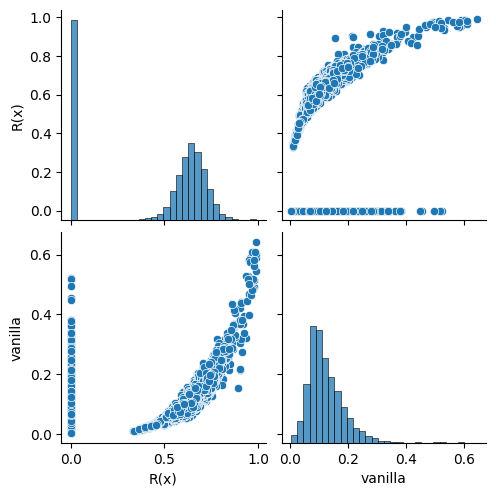

In [65]:
sns.pairplot(results_df[['R(x)','vanilla']],diag_kws={"bins": 30})